In [2]:
# ============================================================
# Final Project: Train neural net on MNIST and evaluate on local digits
# ============================================================

import os
import glob
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------------------
# Device
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


Trainloader loaded: 844
Valloader loaded: 94


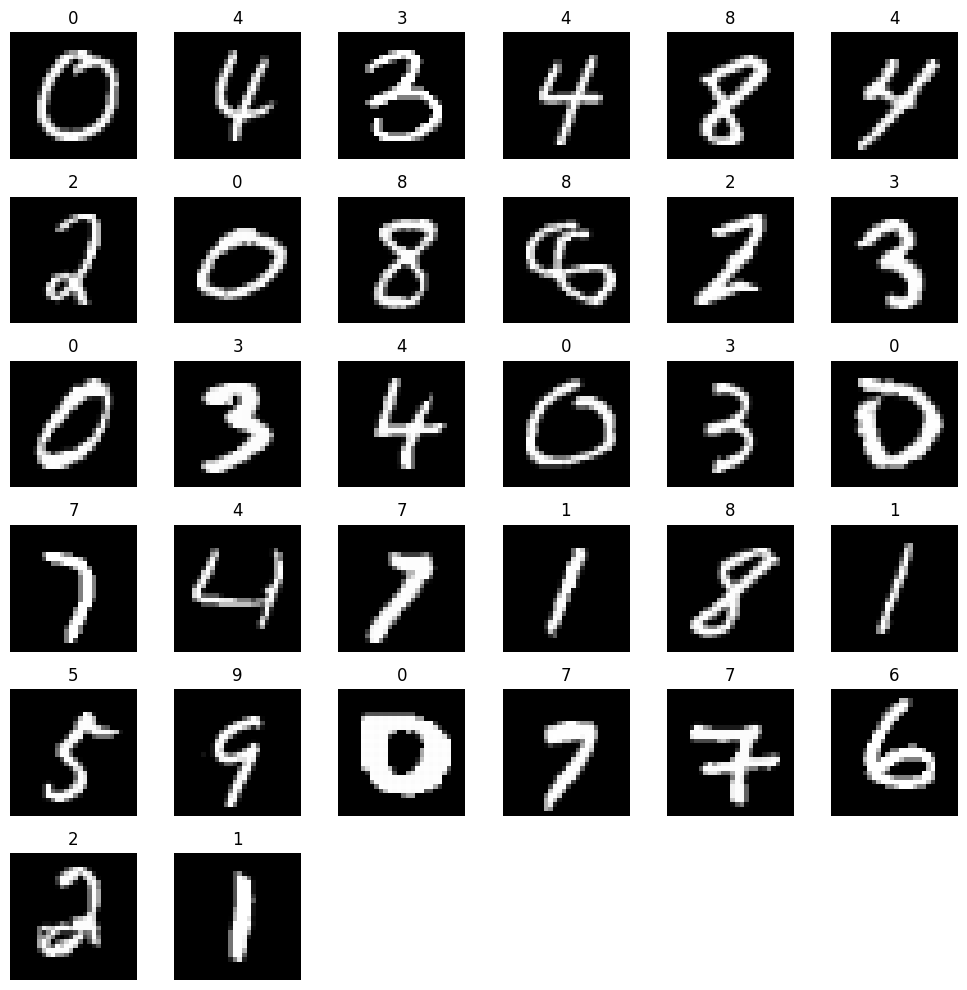

In [13]:

# ============================================================
# 1. Data and augmentation setup
# ============================================================


class RaiseDarkPoint(object):
    def __init__(self, grayRange=(10, 60)):
        self.grayRange = grayRange

    def __call__(self, img):
        arr = np.array(img).astype(np.float32)
        grayVal = np.random.uniform(*self.grayRange)
        mask = arr < 30
        arr[mask] = arr[mask] + grayVal
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8), mode="L")


class LowerWhitePoint(object):
    def __init__(self, factorRange=(0.7, 0.95)):
        self.factorRange = factorRange

    def __call__(self, img):
        arr = np.array(img, dtype=np.float32)
        factor = float(np.random.uniform(self.factorRange[0], self.factorRange[1]))
        arr = arr * factor
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8), mode="L")


class AddNoise(object):
    def __init__(self, noiseStd=0.05):
        self.noiseStd = noiseStd

    def __call__(self, img):
        arr = np.array(img).astype(np.float32)
        noise = np.random.normal(0, self.noiseStd * 255, arr.shape)
        arr = arr + noise
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8), mode="L")


class BubblyDigits(object):
    def __init__(self, blurRange=(0.4, 1.0), contrastRange=(1.1, 1.6)):
        self.blurRange = blurRange
        self.contrastRange = contrastRange

    def __call__(self, img):
        sigma = float(np.random.uniform(self.blurRange[0], self.blurRange[1]))
        img = img.filter(ImageFilter.GaussianBlur(radius=sigma))
        c = float(np.random.uniform(self.contrastRange[0], self.contrastRange[1]))
        img = ImageEnhance.Contrast(img).enhance(c)
        return img


class JPEGCompression(object):
    def __init__(self, qualityRange=(40, 80)):
        self.qualityRange = qualityRange

    def __call__(self, img):
        q = int(np.random.randint(self.qualityRange[0], self.qualityRange[1]))
        buf = BytesIO()
        img.save(buf, format="JPEG", quality=q)
        buf.seek(0)
        return Image.open(buf).convert("L")


trainTransform = transforms.Compose(
    [
        transforms.RandomApply(
            [
                transforms.Pad(4, fill=0),
                transforms.RandomCrop(28),
            ],
            p=0.5,
        ),
        transforms.RandomApply(
            [
                transforms.RandomAffine(
                    degrees=(-5, 20),
                    translate=(0.25, 0.25),
                    scale=(0.6, 1.1),
                    fill=0,
                )
            ],
            p=0.5,
        ),
        transforms.RandomApply([AddNoise()], p=0.1),
        transforms.RandomApply([BubblyDigits()], p=0.5),
        transforms.RandomApply([LowerWhitePoint()], p=0.4),
        transforms.RandomApply([RaiseDarkPoint()], p=0.4),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))], p=1
        ),
        transforms.RandomApply([JPEGCompression()], p=0.25),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


def PreprocessSingle(image):
    if image.mode != "RGB":
        image = image.convert("RGB")

    blurred = image.filter(ImageFilter.GaussianBlur(radius=0.75))
    arr = np.array(blurred).astype(np.float32)
    gray = arr.mean(axis=2)

    minVal = gray.min()
    maxVal = gray.max()

    if maxVal - minVal < 1e-6:
        stretched = np.zeros_like(gray)
    else:
        stretched = (gray - minVal) / (maxVal - minVal) * 255.0

    stretched = stretched.astype(np.uint8)
    return Image.fromarray(stretched, mode="L")


# -----------------------------
# MNIST train/val/test split
# -----------------------------
fullTrainAug = datasets.MNIST(
    "~/.pytorch/MNIST_data/", download=True, train=True, transform=trainTransform
)
fullTrainPlain = datasets.MNIST(
    "~/.pytorch/MNIST_data/", download=True, train=True, transform=transform
)

trainSize = int(0.9 * len(fullTrainAug))
valSize = len(fullTrainAug) - trainSize

indices = torch.randperm(len(fullTrainAug)).tolist()
trainIdx = indices[:trainSize]
valIdx = indices[trainSize:]

#trainSet = Subset(fullTrainAug, trainIdx)   # with augmentation
#valSet = Subset(fullTrainPlain, valIdx)     # no augmentation

trainSet = Subset(fullTrainPlain, trainIdx)   # plain ToTensor+Normalize
valSet = Subset(fullTrainPlain, valIdx)     # still plain

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, shuffle=True)
valLoader = torch.utils.data.DataLoader(valSet, batch_size=64, shuffle=False)

testSet = datasets.MNIST(
    "~/.pytorch/MNIST_data/", download=True, train=False, transform=transform
)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

print("Trainloader loaded:", len(trainLoader))
print("Valloader loaded:", len(valLoader))

dataIter = iter(trainLoader)
imgs, labels = next(dataIter)
imgsVis = imgs * 0.5 + 0.5

plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(6, 6, i + 1)
    plt.imshow(imgsVis[i].squeeze().cpu(), cmap="gray")
    plt.title(labels[i].item())
    plt.axis("off")
plt.tight_layout()
plt.show(block=False)
plt.pause(0.001)




In [14]:
# ============================================================
# 2. Model definition
# ============================================================


class MNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x


model = MNISTMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=2,
)

print(model)


MNISTMLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


Epoch 1/15, Train Loss: 0.3198, Val Loss: 0.1322 Learning Rate: 0.000500
Epoch 2/15, Train Loss: 0.1424, Val Loss: 0.0879 Learning Rate: 0.000500
Epoch 3/15, Train Loss: 0.1061, Val Loss: 0.0861 Learning Rate: 0.000500
Epoch 4/15, Train Loss: 0.0930, Val Loss: 0.0764 Learning Rate: 0.000500
Epoch 5/15, Train Loss: 0.0848, Val Loss: 0.0732 Learning Rate: 0.000500
Epoch 6/15, Train Loss: 0.0737, Val Loss: 0.0742 Learning Rate: 0.000500
Epoch 7/15, Train Loss: 0.0684, Val Loss: 0.0665 Learning Rate: 0.000500
Epoch 8/15, Train Loss: 0.0618, Val Loss: 0.0696 Learning Rate: 0.000500
Epoch 9/15, Train Loss: 0.0564, Val Loss: 0.0621 Learning Rate: 0.000500
Epoch 10/15, Train Loss: 0.0520, Val Loss: 0.0669 Learning Rate: 0.000500
Epoch 11/15, Train Loss: 0.0502, Val Loss: 0.0649 Learning Rate: 0.000500
Epoch 12/15, Train Loss: 0.0491, Val Loss: 0.0681 Learning Rate: 0.000250
Epoch 13/15, Train Loss: 0.0350, Val Loss: 0.0602 Learning Rate: 0.000250
Epoch 14/15, Train Loss: 0.0301, Val Loss: 0.06

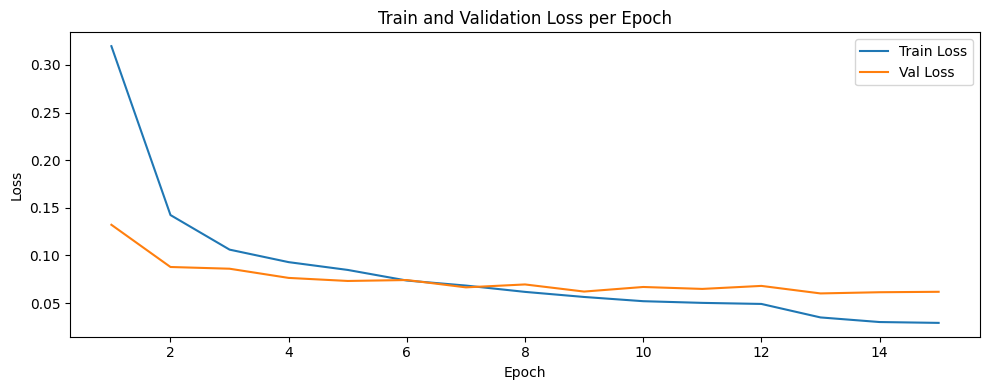

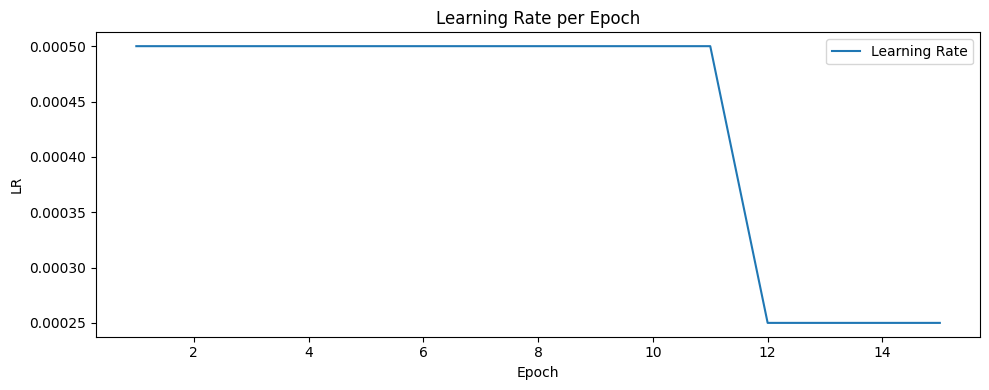

In [15]:
# ============================================================
# 3. Training + validation loop
# ============================================================

numEpochs = 15
epochTrainLosses = []
valLosses = []
learningRates = []

for epoch in range(numEpochs):
    model.train()
    runningLoss = 0.0

    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        runningLoss += loss.item()

    epochLoss = runningLoss / len(trainLoader)
    epochTrainLosses.append(epochLoss)

    # ---- validation loss (no gradient, no augmentation) ----
    model.eval()
    valRunningLoss = 0.0
    with torch.no_grad():
        for images, labels in valLoader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            valRunningLoss += loss.item()

    valLoss = valRunningLoss / len(valLoader)
    valLosses.append(valLoss)

    # Step scheduler on validation loss, then read scalar LR
    scheduler.step(valLoss)
    currentLr = optimizer.param_groups[0]["lr"]
    learningRates.append(currentLr)

    print(
        f"Epoch {epoch+1}/{numEpochs}, "
        f"Train Loss: {epochLoss:.4f}, Val Loss: {valLoss:.4f} "
        f"Learning Rate: {currentLr:.6f}"
    )

print("Training complete.")

epochs = range(1, numEpochs + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, epochTrainLosses, label="Train Loss")
plt.plot(epochs, valLosses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss per Epoch")
plt.legend()
plt.tight_layout()
plt.show(block=False)
plt.pause(0.001)


# Learning rate per epoch
plt.figure(figsize=(10, 4))
plt.plot(epochs, learningRates, label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate per Epoch")
plt.legend()
plt.tight_layout()
plt.show(block=False)
plt.pause(0.001)



In [22]:
# ============================================================
# 4. Evaluation helpers
# ============================================================

# CHANGE THE FIRST BIT OF THIS FUNCTION
def EvaluateWithDetails(loader, name="Dataset"):
    model.eval()
    allPreds, allLabels = [], []
    allGroupIDs = []

    with torch.no_grad():
        for data in loader:
            if len(data) == 3:
                images, labels, group_ids = data
            elif len(data) == 2:
                images, labels = data
                group_ids = torch.zeros_like(labels)
            else:
                continue

            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            _, preds = torch.max(logits, 1)
            allPreds.extend(preds.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())
            allGroupIDs.extend(group_ids.cpu().numpy())

    allPreds = np.array(allPreds)
    allLabels = np.array(allLabels)
    allGroupIDs = np.array(allGroupIDs)

    accuracy = (allPreds == allLabels).mean()
    errorRate = 1.0 - accuracy

    print(f"\n==== {name} RESULTS ====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {errorRate:.4f}")

    print("\nClassification Report:")
    print(classification_report(allLabels, allPreds, digits=4))

    print("Confusion Matrix:")
    print(confusion_matrix(allLabels, allPreds))

    if np.any(allGroupIDs != 0):
        return allPreds, allLabels, allGroupIDs

    return accuracy

# MADE A NEW FUNCTION TO PLOT GROUP ACCURACY
def PlotGroupAccuracy(allPreds, allLabels, allGroupIDs):
    uniqueGroups = np.unique(allGroupIDs)
    groupAccuracies = {}

    for groupID in uniqueGroups:
        mask = (allGroupIDs == groupID)
        groupPreds = allPreds[mask]
        groupLabels = allLabels[mask]

        if len(groupLabels) > 0:
            accuracy = (groupPreds == groupLabels).mean()
            groupAccuracies[groupID] = accuracy
            print(f"Group {groupID} Accuracy: {accuracy:.4f} ({len(groupLabels)} samples)")

    groups = list(groupAccuracies.keys())
    accuracies = list(groupAccuracies.values())

    plt.figure(figsize=(10, 5))
    plt.bar([str(g) for g in groups], accuracies, color='skyblue')
    plt.ylim(0, 1.05)
    plt.xlabel("Group ID")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy per Student Group W/ Preprocessing")
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.show()

mnistAcc = EvaluateWithDetails(testLoader, "MNIST Test Set")
print("MNIST test accuracy (float):", float(mnistAcc))



==== MNIST Test Set RESULTS ====
Accuracy: 0.9849
Error Rate: 0.0151

Classification Report:
              precision    recall  f1-score   support

           0     0.9858    0.9918    0.9888       980
           1     0.9938    0.9930    0.9934      1135
           2     0.9855    0.9855    0.9855      1032
           3     0.9880    0.9822    0.9851      1010
           4     0.9837    0.9817    0.9827       982
           5     0.9843    0.9843    0.9843       892
           6     0.9874    0.9833    0.9854       958
           7     0.9824    0.9796    0.9810      1028
           8     0.9835    0.9815    0.9825       974
           9     0.9736    0.9851    0.9793      1009

    accuracy                         0.9849     10000
   macro avg     0.9848    0.9848    0.9848     10000
weighted avg     0.9849    0.9849    0.9849     10000

Confusion Matrix:
[[ 972    1    0    0    0    0    2    1    2    2]
 [   0 1127    0    1    0    1    2    1    3    0]
 [   1    2 1017    2  

Handwritten digits found: 330


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



==== Handwritten Digits RESULTS ====
Accuracy: 0.7515
Error Rate: 0.2485

Classification Report:
              precision    recall  f1-score   support

           0     0.9600    0.7273    0.8276        33
           1     0.9474    0.5455    0.6923        33
           2     0.6667    0.9091    0.7692        33
           3     0.6522    0.9091    0.7595        33
           4     0.8929    0.7576    0.8197        33
           5     0.8108    0.9091    0.8571        33
           6     0.7647    0.7879    0.7761        33
           7     0.5854    0.7273    0.6486        33
           8     0.8148    0.6667    0.7333        33
           9     0.6786    0.5758    0.6230        33

    accuracy                         0.7515       330
   macro avg     0.7773    0.7515    0.7506       330
weighted avg     0.7773    0.7515    0.7506       330

Confusion Matrix:
[[24  0  1  2  0  1  4  0  0  1]
 [ 0 18  8  2  1  1  0  1  2  0]
 [ 0  0 30  1  0  0  1  0  1  0]
 [ 0  0  0 30  0  1  0  1 

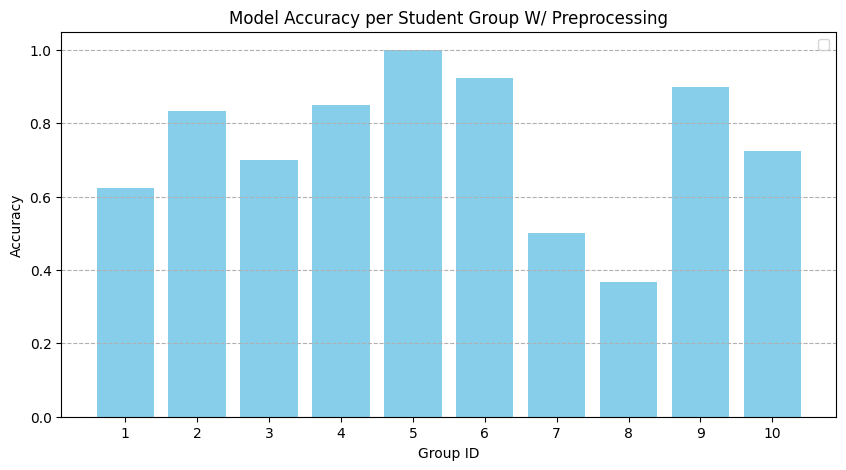

In [ ]:
# ============================================================
# 5. Local handwritten digit dataset
# ============================================================


class HandwrittenDigits(Dataset):
    def __init__(self, root, transform=None):
        self.paths = sorted(glob.glob(os.path.join(root, "*.png")))
        self.transform = transform
        self.labels = [int(os.path.basename(p).split("-")[0]) for p in self.paths]
        self.group_ids = [int(os.path.basename(p).split("-")[1]) for p in self.paths] # ADDED THIS

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        img = PreprocessSingle(img)
        img = img.resize((28, 28))
        if self.transform is not None:
            img = self.transform(img)
        return img, self.labels[idx], self.group_ids[idx]


digitsRoot = "../digits"
handSet = HandwrittenDigits(digitsRoot, transform)

handLoader = torch.utils.data.DataLoader(handSet, batch_size=64, shuffle=False)

print("Handwritten digits found:", len(handSet))

# CHANGED THIS IF WE HAVE DATA
if len(handSet) > 0:
    allPreds, allLabels, allGroupIDs = EvaluateWithDetails(handLoader, "Handwritten Digits")

    PlotGroupAccuracy(allPreds, allLabels, allGroupIDs)
else:
    print("No handwritten digits found.")

torch.save(model.state_dict(), "model.pth")